In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
register_matplotlib_converters()
import seaborn as sns

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px

In [2]:
!ls data

building_metadata.csv    test.csv                 valid_sm_custom_3fold.h5
leak.feather             test_data.h5             weather_test.csv
leak_data.h5             train.csv                weather_train.csv
leakage.feather          train_data.h5


In [3]:
train_data = pd.read_hdf("data/train_data.h5", "train_data")

In [4]:
building_metadata = pd.read_csv("data/building_metadata.csv")

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19678704 entries, 0 to 19678703
Data columns (total 12 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
air_temperature       float16
dew_temperature       float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(5), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 863.3+ MB


number of time series

In [6]:
train_data.loc[:, ["building_id","meter"]].drop_duplicates()

building_id  meter
0                  46      0
1                 105      0
2                 106      0
3                 106      3
4                 107      0
...               ...    ...
16479603         1221      0
17156341         1413      1
17435626          604      0
17995099         1327      2
18553465          403      0

[2380 rows x 2 columns]

In [7]:
train_data.meter_reading.describe()

count    1.967870e+07
mean     2.041720e+03
std      1.552932e+05
min      0.000000e+00
25%      2.075000e+01
50%      7.987000e+01
75%      2.631800e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

number of 0 readings

In [7]:
len(train_data.query("meter_reading == 0"))

1343496

### number of samples by time serie

In [314]:
n_samples_by_ts = train_data.groupby(["building_id","meter"]).size().reset_index(name='counts')

In [9]:
n_samples_by_ts.counts.describe()

count    2380.000000
mean     8268.363025
std      1091.557136
min        20.000000
25%      8445.500000
50%      8771.000000
75%      8783.000000
max      8784.000000
Name: counts, dtype: float64

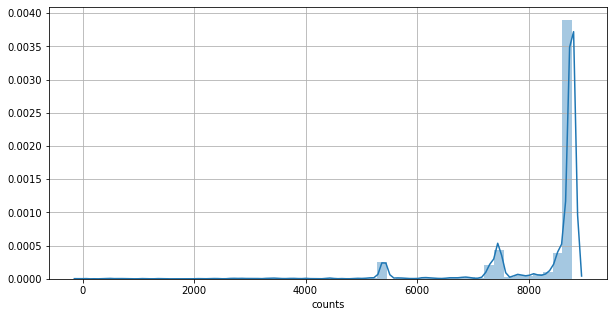

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(n_samples_by_ts.counts)
plt.grid()
plt.show()

### number of building by site 

In [11]:
(train_data.loc[:, ["site_id","building_id"]]
 .groupby("site_id")
 .apply(lambda df: df.building_id.unique().size)
 .reset_index(name="n_buildings"))

site_id  n_buildings
0         0          105
1         1           51
2         2          135
3         3          274
4         4           91
5         5           89
6         6           44
7         7           15
8         8           70
9         9          124
10       10           30
11       11            5
12       12           36
13       13          154
14       14          102
15       15          124

***
### ts visualization

In [12]:
def plot_ts_by_site(site_id):
    train_data_cut = (train_data.query("site_id == @site_id")
                      .loc[:, ["timestamp","building_id","meter","meter_reading"]])
    for building_id in train_data_cut.building_id.unique():
        for meter in train_data_cut.meter.unique():
            print(f"building_id: {building_id} - meter: {meter}".center(90, "-"))
            ts = train_data_cut.query("building_id == @building_id & meter == @meter")
            plt.figure(figsize=(18,4))
            plt.plot_date(x=ts.timestamp.values, y=ts.meter_reading.values, fmt="r-")
            plt.grid()
            plt.show()

--------------------------------building_id: 46 - meter: 0--------------------------------


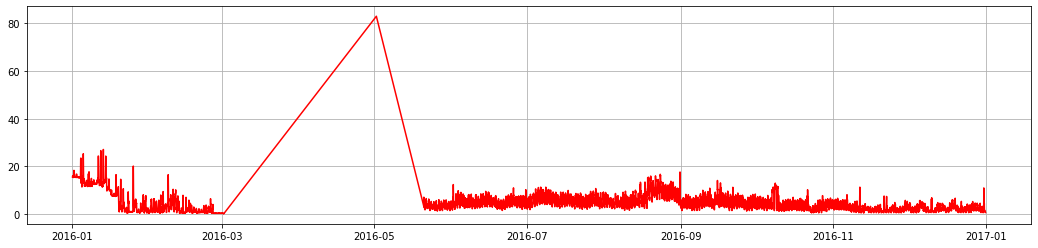

--------------------------------building_id: 46 - meter: 1--------------------------------


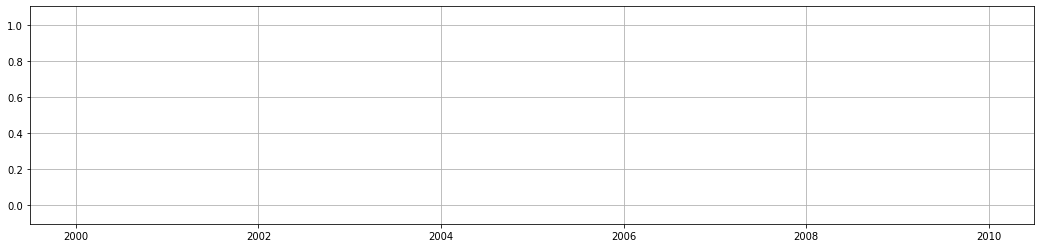

--------------------------------building_id: 7 - meter: 0---------------------------------


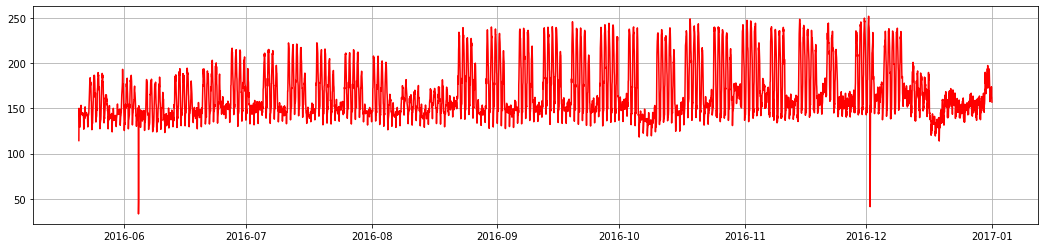

--------------------------------building_id: 7 - meter: 1---------------------------------


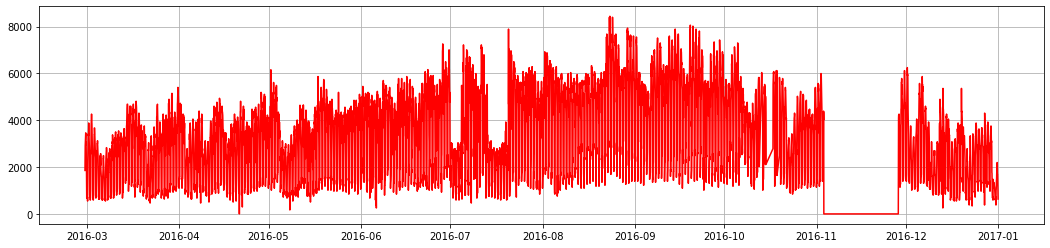

--------------------------------building_id: 9 - meter: 0---------------------------------


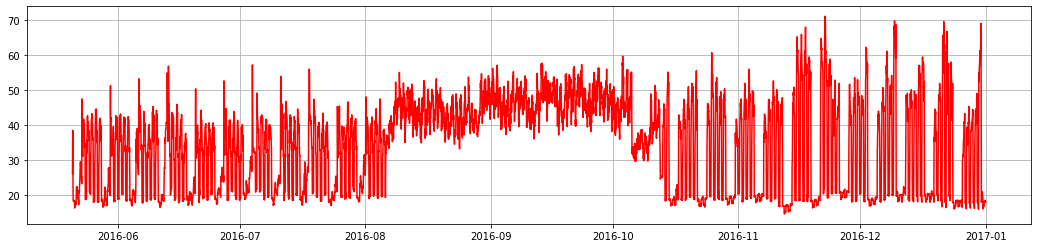

--------------------------------building_id: 9 - meter: 1---------------------------------


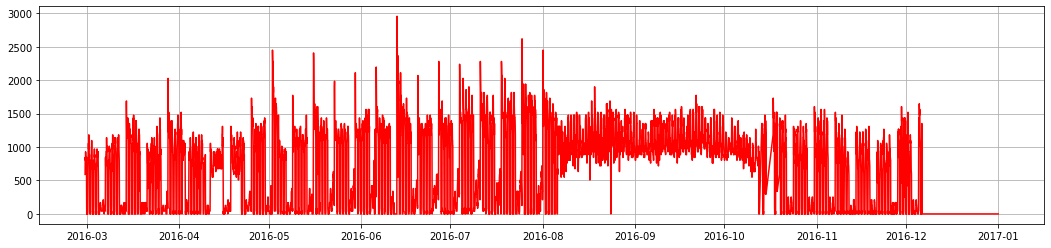

--------------------------------building_id: 13 - meter: 0--------------------------------


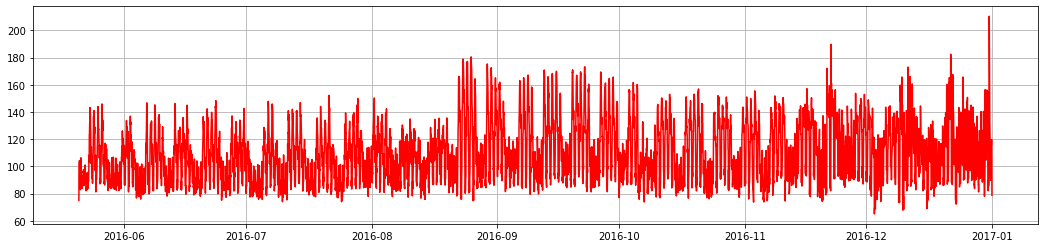

--------------------------------building_id: 13 - meter: 1--------------------------------


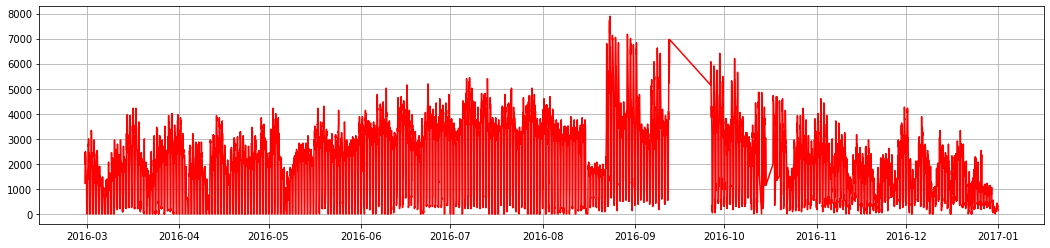

--------------------------------building_id: 14 - meter: 0--------------------------------


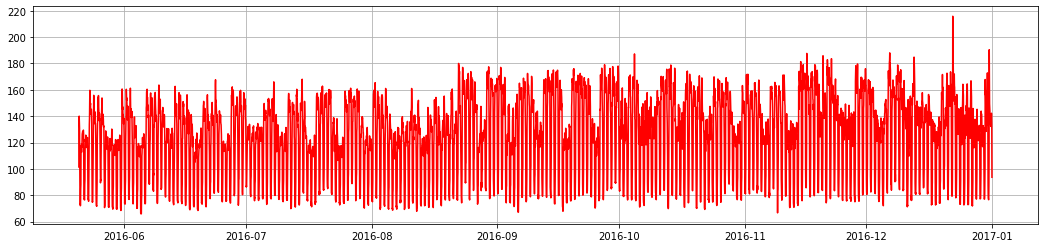

--------------------------------building_id: 14 - meter: 1--------------------------------


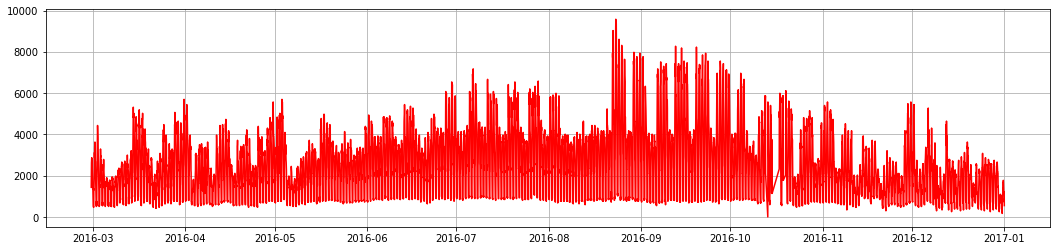

--------------------------------building_id: 15 - meter: 0--------------------------------


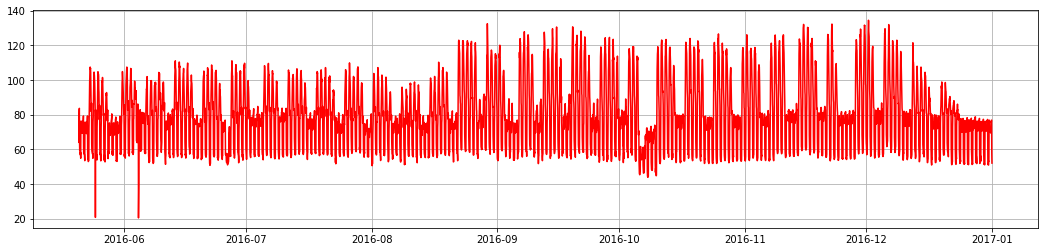

--------------------------------building_id: 15 - meter: 1--------------------------------


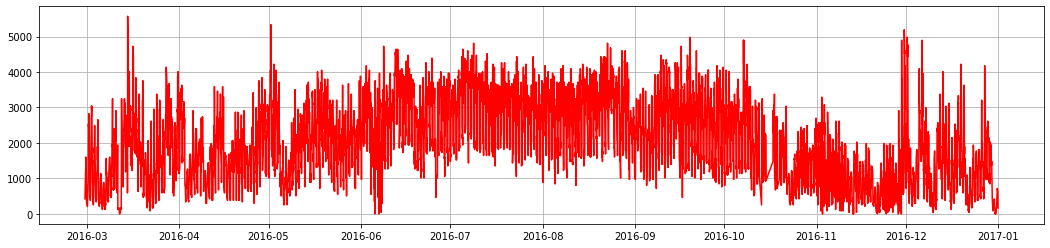

--------------------------------building_id: 29 - meter: 0--------------------------------


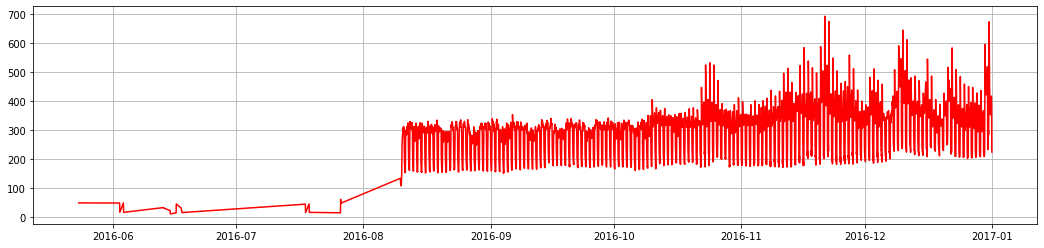

--------------------------------building_id: 29 - meter: 1--------------------------------


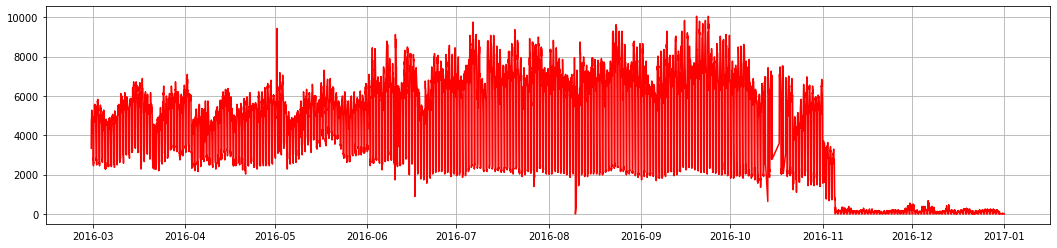

--------------------------------building_id: 30 - meter: 0--------------------------------


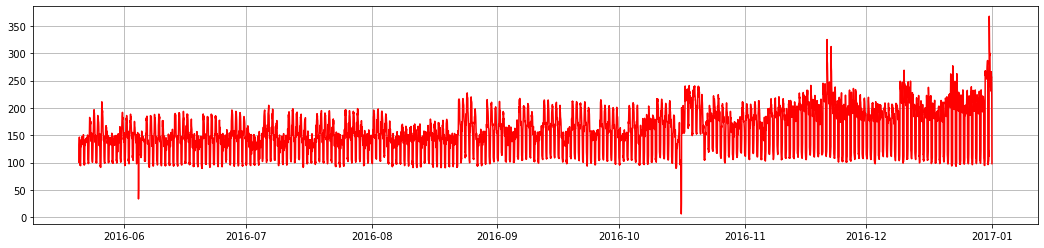

--------------------------------building_id: 30 - meter: 1--------------------------------


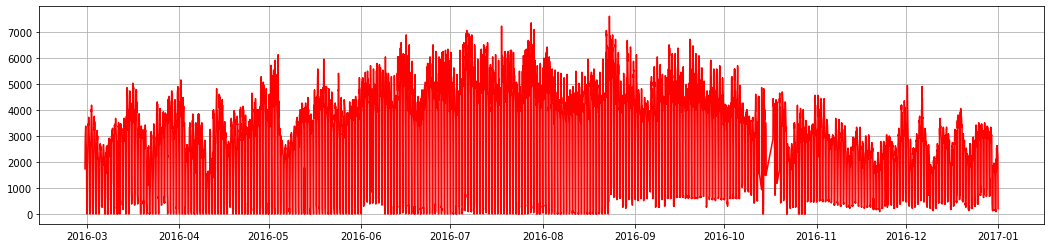

--------------------------------building_id: 31 - meter: 0--------------------------------


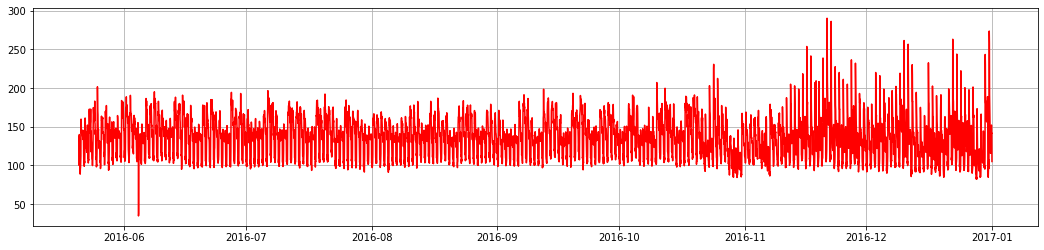

--------------------------------building_id: 31 - meter: 1--------------------------------


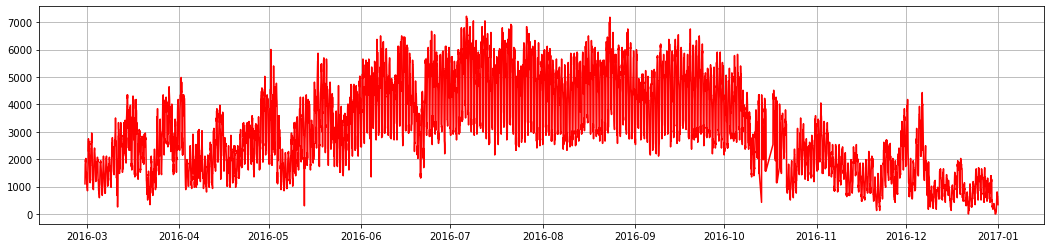

--------------------------------building_id: 43 - meter: 0--------------------------------


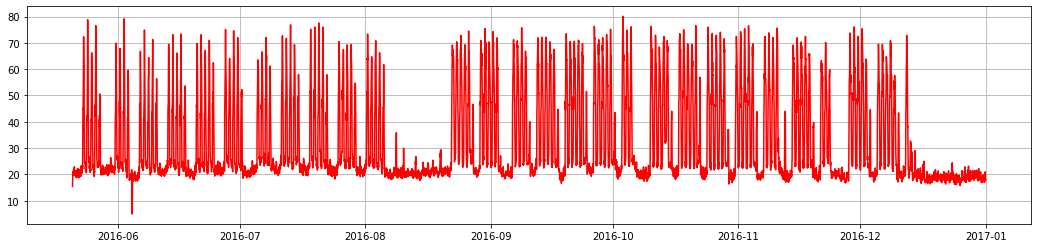

--------------------------------building_id: 43 - meter: 1--------------------------------


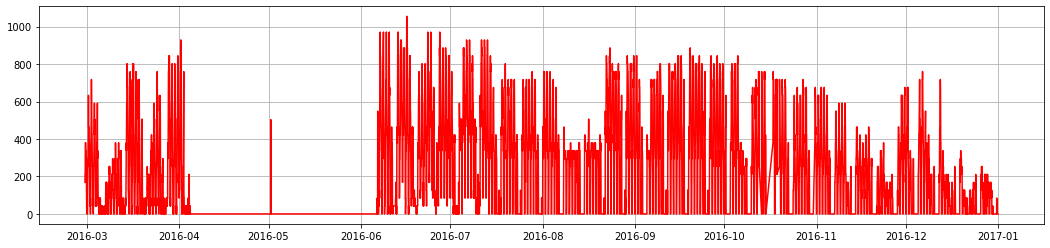

--------------------------------building_id: 50 - meter: 0--------------------------------


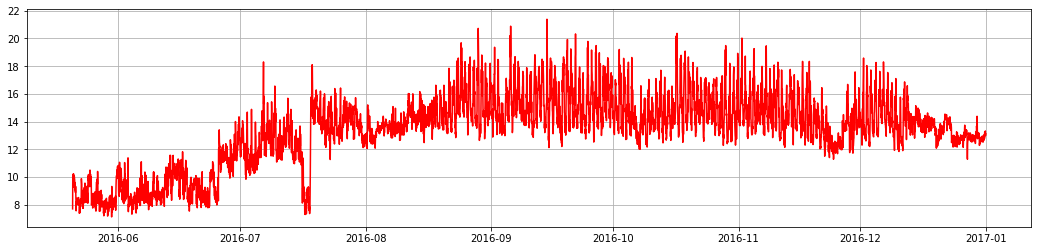

--------------------------------building_id: 50 - meter: 1--------------------------------


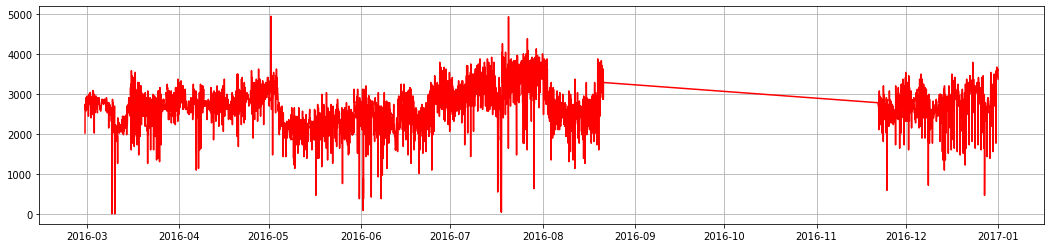

--------------------------------building_id: 55 - meter: 0--------------------------------


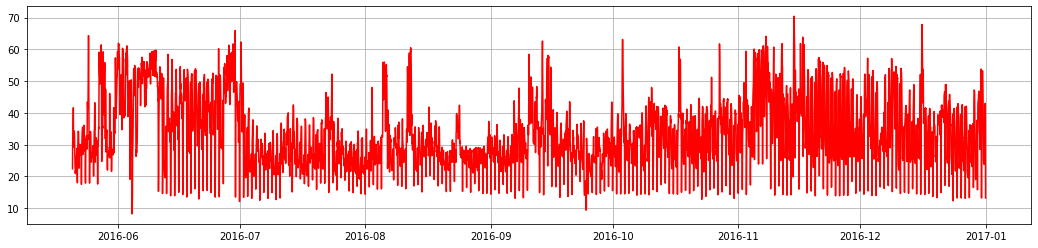

--------------------------------building_id: 55 - meter: 1--------------------------------


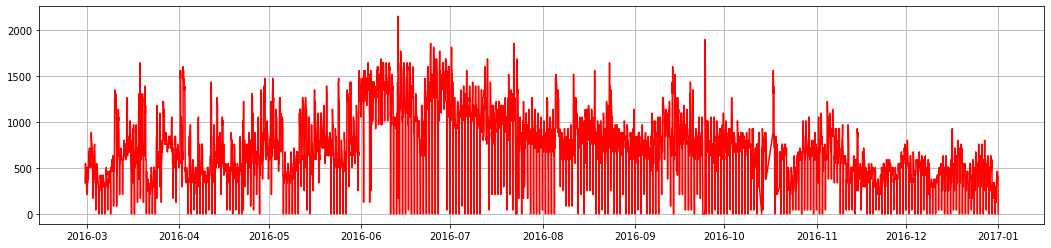

--------------------------------building_id: 60 - meter: 0--------------------------------


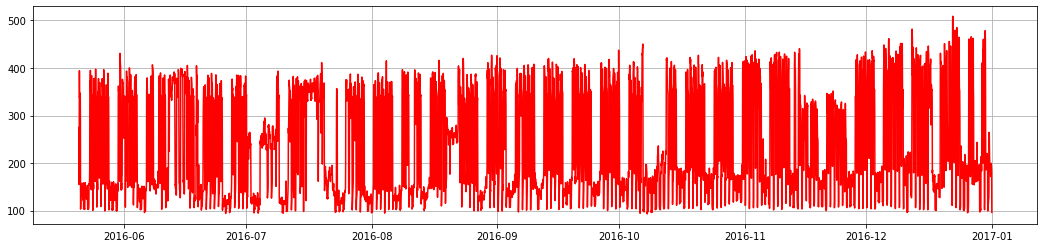

--------------------------------building_id: 60 - meter: 1--------------------------------


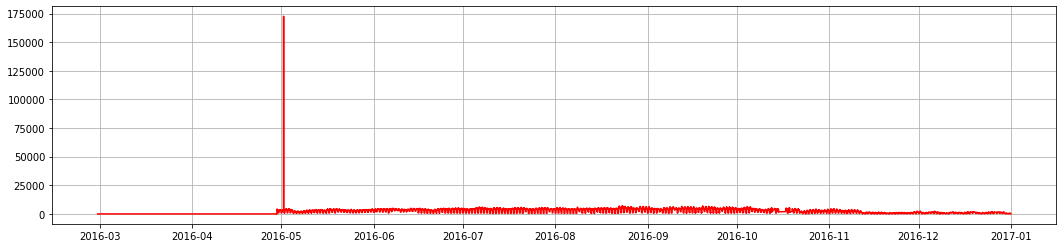

--------------------------------building_id: 75 - meter: 0--------------------------------


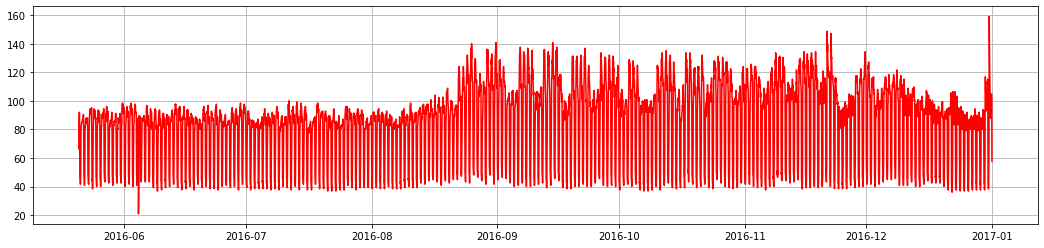

--------------------------------building_id: 75 - meter: 1--------------------------------


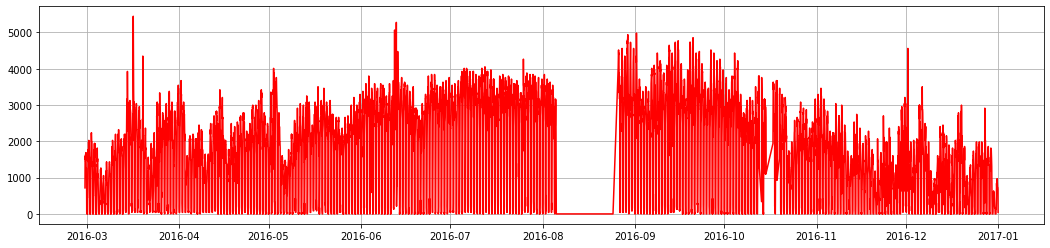

--------------------------------building_id: 76 - meter: 0--------------------------------


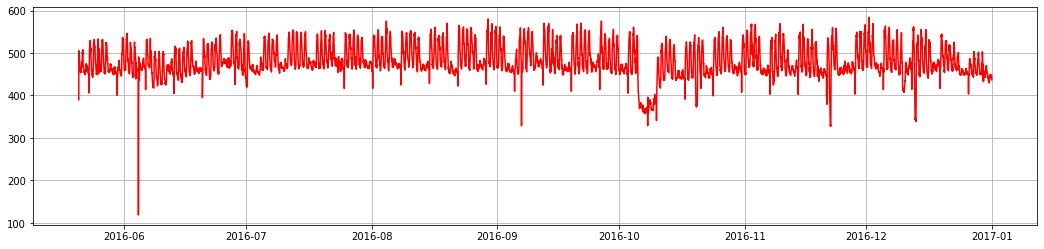

--------------------------------building_id: 76 - meter: 1--------------------------------


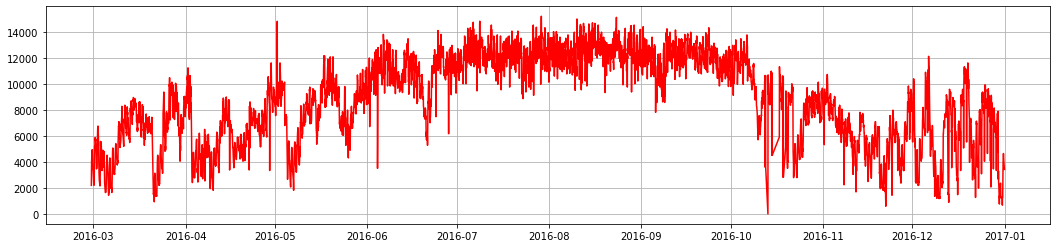

--------------------------------building_id: 78 - meter: 0--------------------------------


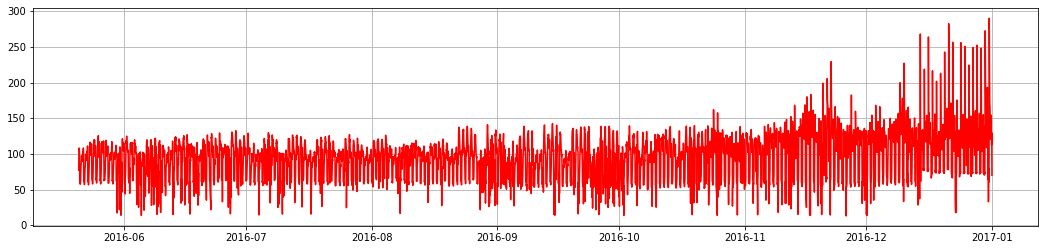

--------------------------------building_id: 78 - meter: 1--------------------------------


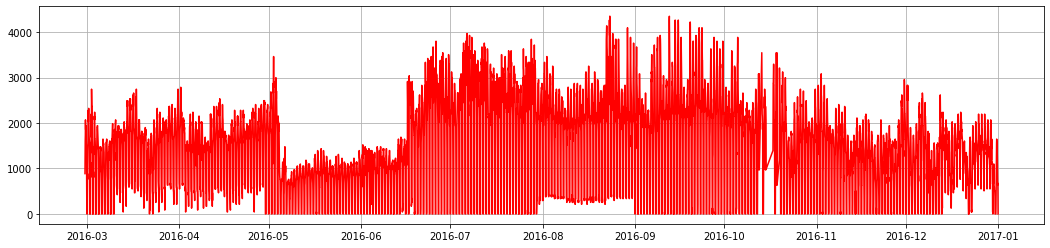

--------------------------------building_id: 82 - meter: 0--------------------------------


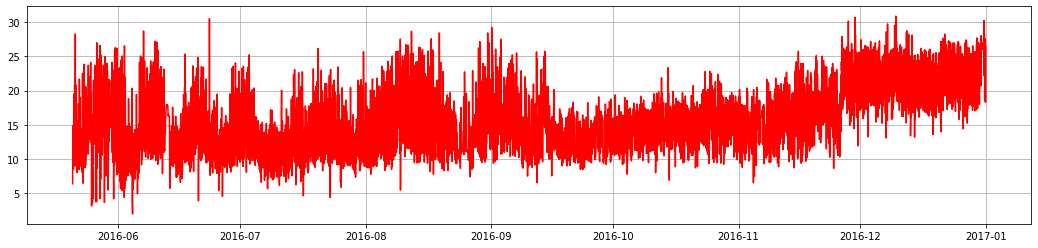

--------------------------------building_id: 82 - meter: 1--------------------------------


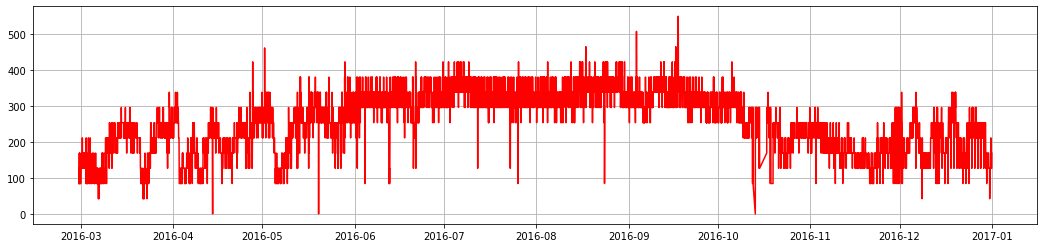

--------------------------------building_id: 91 - meter: 0--------------------------------


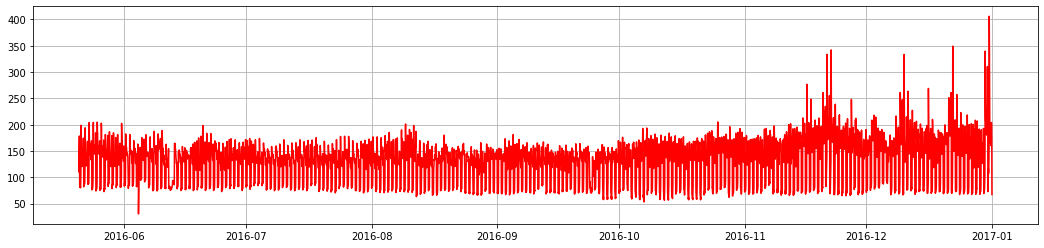

--------------------------------building_id: 91 - meter: 1--------------------------------


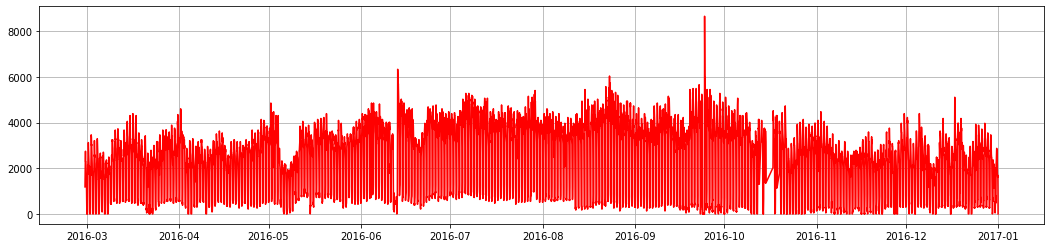

--------------------------------building_id: 92 - meter: 0--------------------------------


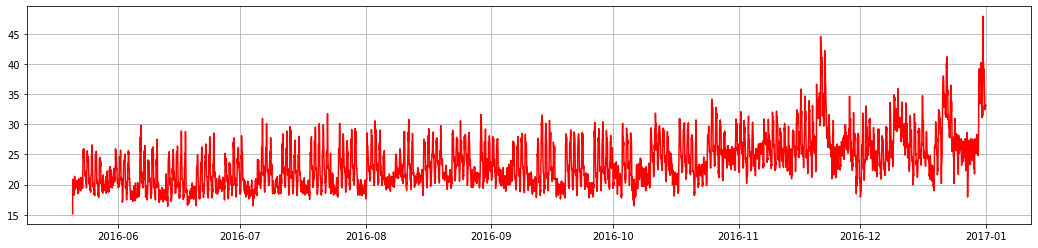

--------------------------------building_id: 92 - meter: 1--------------------------------


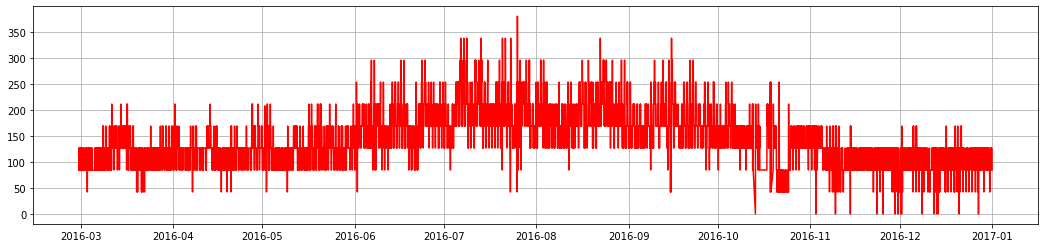

--------------------------------building_id: 95 - meter: 0--------------------------------


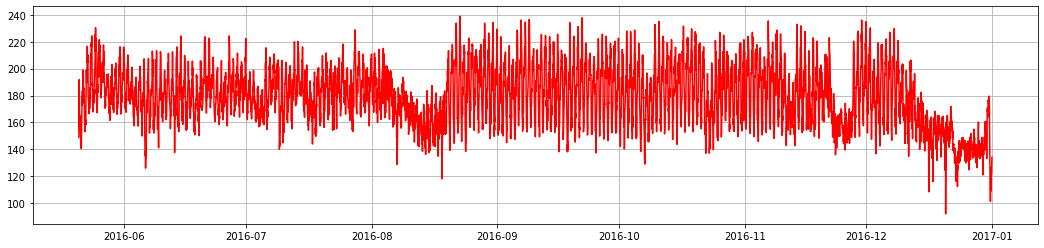

--------------------------------building_id: 95 - meter: 1--------------------------------


KeyboardInterrupt: 

In [13]:
plot_ts_by_site(0)

***
### data cleaning for `site_id=0`

In [ ]:
train_data_cut = train_data.query("site_id == 0")
ts_uid_values = train_data_cut.loc[:, ["building_id", "meter"]].drop_duplicates()
delete_idx = pd.Index(np.array([], dtype=int))
for i,row in ts_uid_values.iterrows():
    ts = train_data_cut.query("building_id == @row.building_id & meter == @row.meter")
    if ts.query("timestamp < '2016-05-20 18:00:00'").meter_reading.quantile(0.75) == 0:
        delete_idx = delete_idx.union(ts.query("timestamp < '2016-05-20 18:00:00'").index)

In [ ]:
train_data.drop(delete_idx, axis=0, inplace=True)

In [ ]:
len(train_data)

***
### hourly patter for air temperature by `site_id`

In [ ]:
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=["timestamp"])
weather_train["hour"] = weather_train.timestamp.dt.hour
hourly_temp = weather_train.groupby(["site_id","hour"])["air_temperature"].mean().reset_index()

In [ ]:
for site_id in hourly_temp.site_id.unique():
    print(f"hourly temperature for site: {site_id}")
    ts = hourly_temp.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.air_temperature.values, "o--")
    plt.grid()
    plt.show()

### fix to set weather data to its local time

In [ ]:
sites_time_corrections = {0:4, 1:0, 2:7, 3:4, 4:7, 5:0, 6:4, 7:4, 8:4,
                          9:5, 10:7, 11:4, 12:0, 13:5, 14:4, 15:4}

def set_localtime(data):
    data = data.copy(deep=True)
    min_timestamp = data.timestamp.min()
    for site_id, hdiff in sites_time_corrections.items():
        idx = data.query("site_id == @site_id").index 
        data.loc[idx, "timestamp"] = data.loc[idx, "timestamp"] - pd.offsets.Hour(hdiff)
    return data.query("timestamp >= @min_timestamp")

In [ ]:
hourly_temp = _weather_train.groupby(["site_id","hour"])["air_temperature"].mean().reset_index()

In [ ]:
for site_id in hourly_temp.site_id.unique():
    print(f"hourly temperature for site: {site_id}")
    ts = hourly_temp.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.air_temperature.values, "o--")
    plt.grid()
    plt.show()

### imputation of missing values in weather data

In [ ]:
weather_train.describe()

In [ ]:
print(weather_train.precip_depth_1_hr.quantile(0.93))
print(weather_train.precip_depth_1_hr.quantile(0.94))

#### number of nans

In [ ]:
weather_train.isna().sum()

In [ ]:
100*weather_train.isna().sum()/weather_train.shape[0]

In [ ]:
weather_train.groupby('site_id').apply(lambda group: group.isna().sum())

In [ ]:
df = (weather_train
      .set_index("timestamp")
      .groupby('site_id')
      .apply(lambda group: group.interpolate(method="time", limit_direction='both'))
      .reset_index())

In [ ]:
df.groupby('site_id').apply(lambda group: group.isna().sum())

***
### hourly patter for meter_reading per `site_id` and for `meter==0`

In [ ]:
train_data["hour"] = train_data.timestamp.dt.hour
train_data_cut = train_data.query("meter == 0")

In [ ]:
hourly_reading = train_data_cut.groupby(["site_id","hour"])["meter_reading"].sum().reset_index()

hourly meter_reading (meter==0) for site: 0


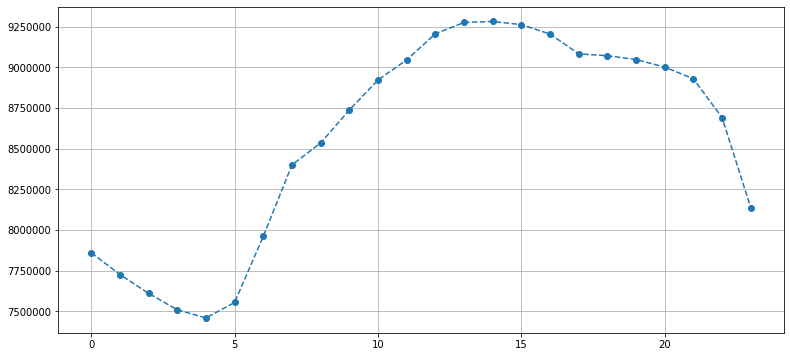

hourly meter_reading (meter==0) for site: 1


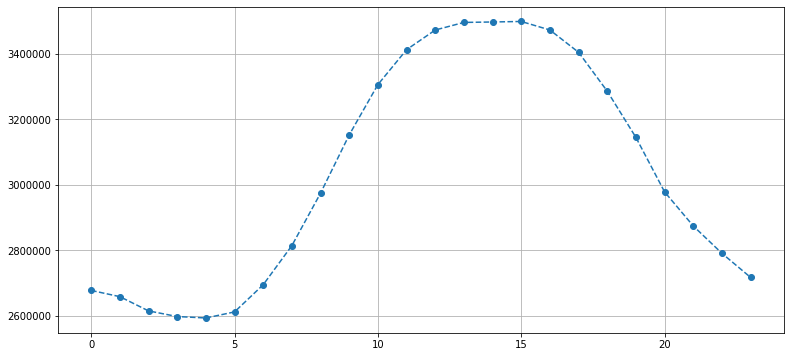

hourly meter_reading (meter==0) for site: 2


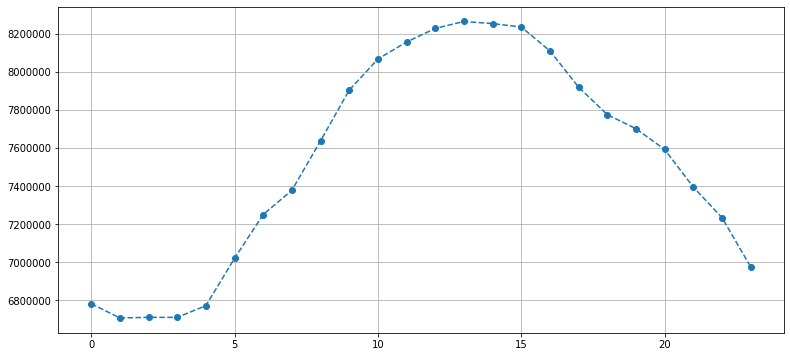

hourly meter_reading (meter==0) for site: 3


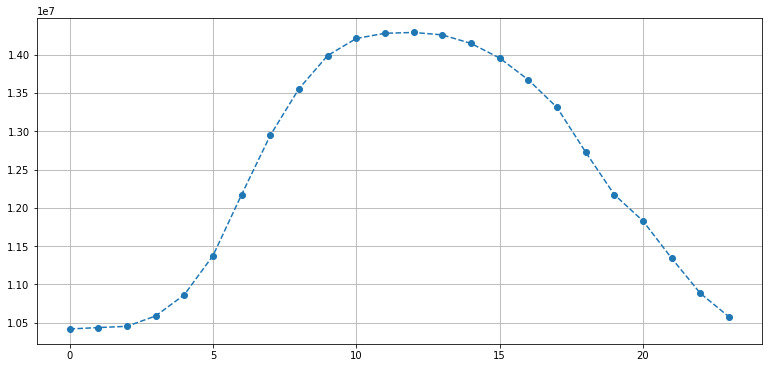

hourly meter_reading (meter==0) for site: 4


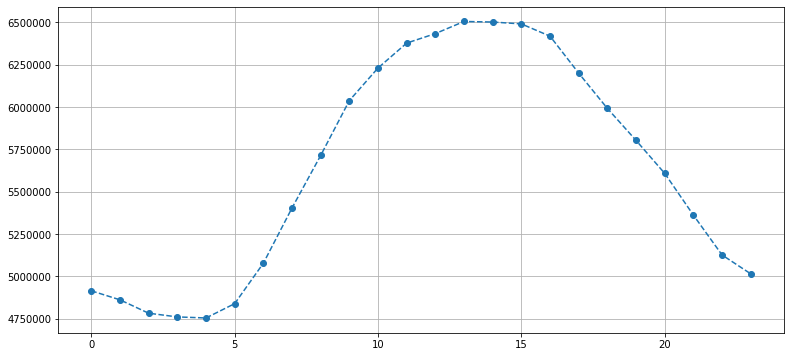

hourly meter_reading (meter==0) for site: 5


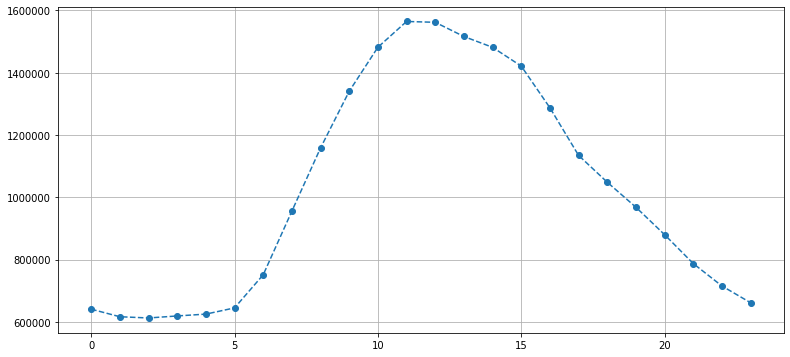

hourly meter_reading (meter==0) for site: 6


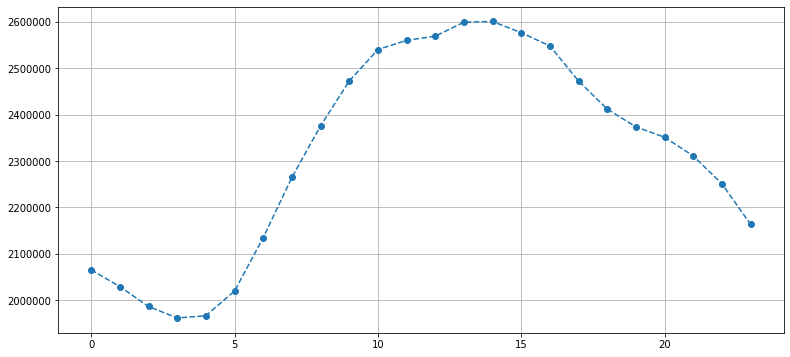

hourly meter_reading (meter==0) for site: 7


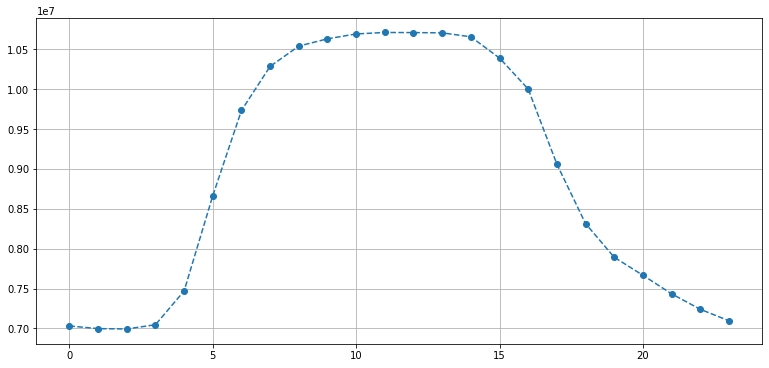

hourly meter_reading (meter==0) for site: 8


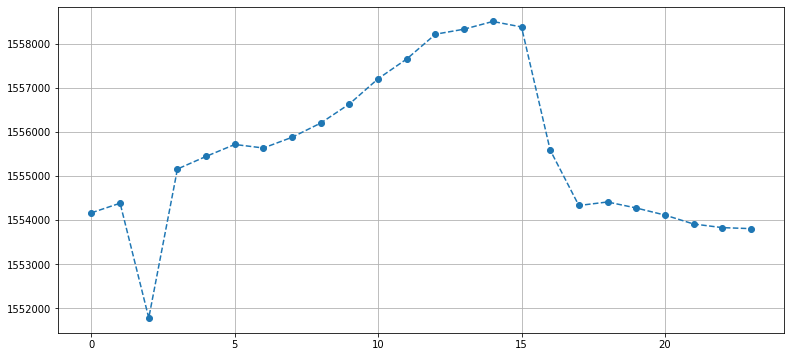

hourly meter_reading (meter==0) for site: 9


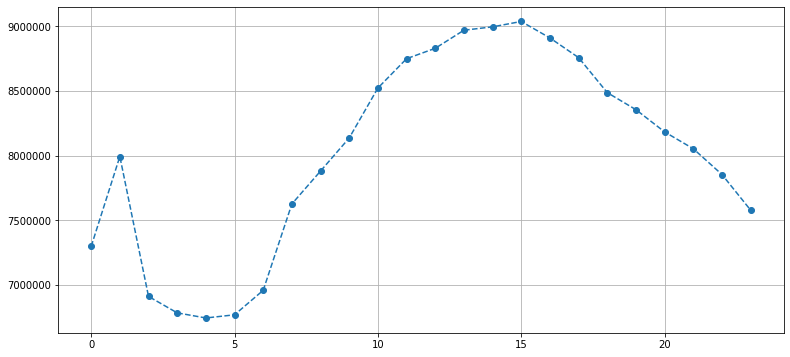

hourly meter_reading (meter==0) for site: 10


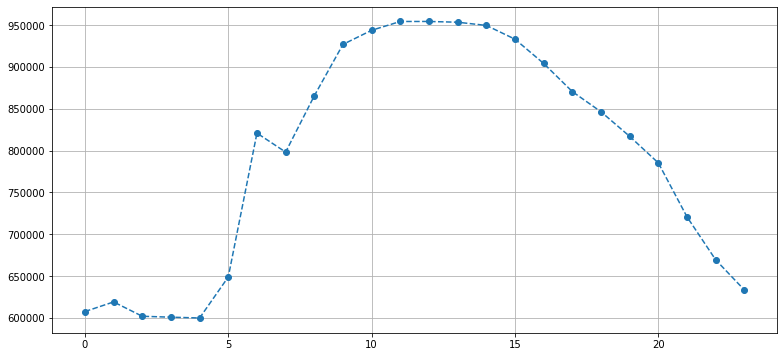

hourly meter_reading (meter==0) for site: 11


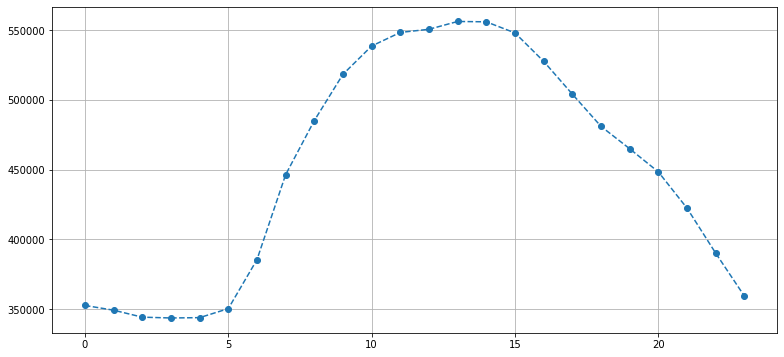

hourly meter_reading (meter==0) for site: 12


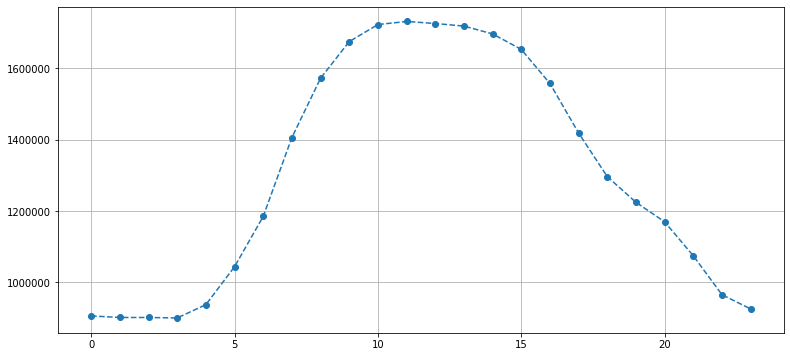

hourly meter_reading (meter==0) for site: 13


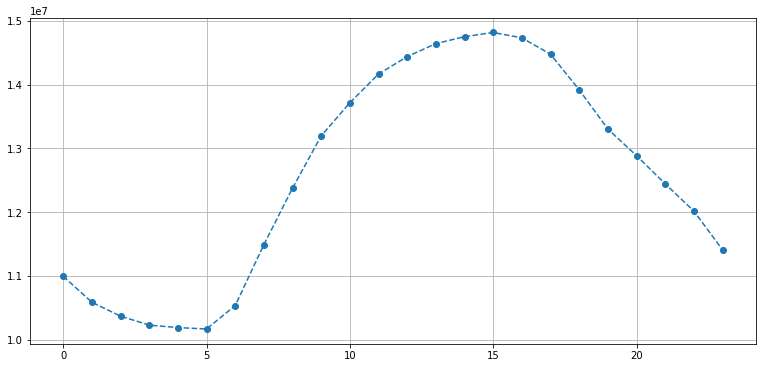

hourly meter_reading (meter==0) for site: 14


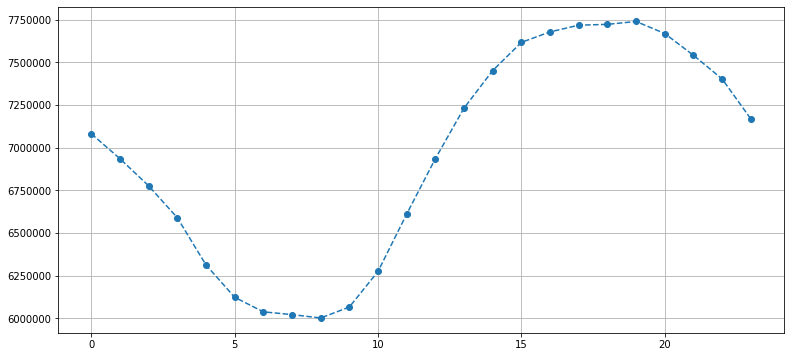

hourly meter_reading (meter==0) for site: 15


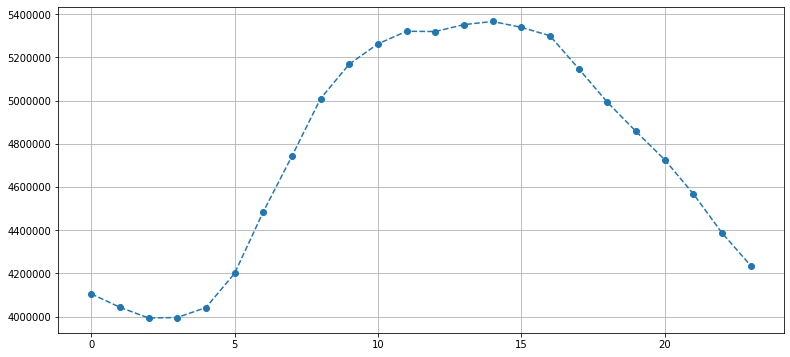

In [43]:
for site_id in hourly_reading.site_id.unique():
    print(f"hourly meter_reading (meter==0) for site: {site_id}")
    ts = hourly_reading.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.meter_reading.values, "o--")
    plt.grid()
    plt.show()

***
### `building_id = 363`

In [8]:
ts = train_data.query("building_id == 363 & meter == 0")

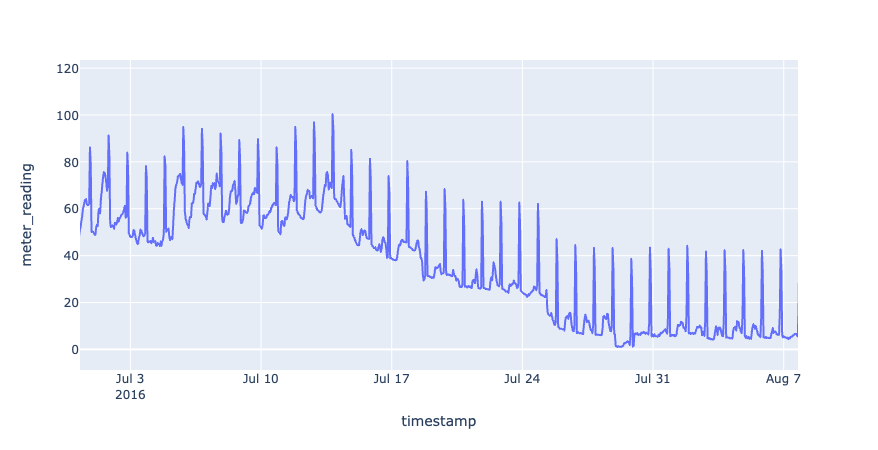

In [10]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

25jul start normal behavior for `building_id = 363` and `meter = 0`

In [12]:
idx = train_data.query("building_id == 363 & meter == 0 & timestamp <= '2016-07-24 23:00:00'").index
train_data.drop(idx, axis=0).reset_index(drop=True)

building_id  meter           timestamp  meter_reading  site_id  \
421               363      0 2016-01-01 00:00:00      32.049999        3   
2618              363      0 2016-01-01 01:00:00      32.570000        3   
4811              363      0 2016-01-01 02:00:00      32.799999        3   
7007              363      0 2016-01-01 03:00:00      33.919998        3   
9200              363      0 2016-01-01 04:00:00      35.580002        3   
...               ...    ...                 ...            ...      ...   
10891828          363      0 2016-07-24 19:00:00      27.270000        3   
10894150          363      0 2016-07-24 20:00:00      62.029999        3   
10896469          363      0 2016-07-24 21:00:00      52.029999        3   
10898788          363      0 2016-07-24 22:00:00      24.020000        3   
10901107          363      0 2016-07-24 23:00:00      23.980000        3   

         primary_use  square_feet  air_temperature  dew_temperature  \
421        Education        69300        10.000000         2.199219   
2618       Education        69300         9.398438         2.800781   
4811       Education        69300         8.898438         2.199219   
7007       Education        69300         7.800781         1.099609   
9200       Education        69300         7.800781         0.600098   
...              ...          ...              ...              ...   
10891828   Education        69300        35.000000        19.406250   
10894150   Education        69300        35.593750        19.406250   
10896469   Education        69300        35.593750        20.593750   
10898788   Education        69300        35.000000        21.093750   
10901107   Education        69300        33.906250        22.203125   

          precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
421                     NaN              1021.0           350.0    4.101562  
2618                    0.0              1021.5           350.0    6.199219  
4811                    0.0              1021.5            10.0    4.601562  
7007                    0.0              1021.5           350.0    7.699219  
9200                    0.0              1022.0           340.0    4.101562  
...                     ...                 ...             ...         ...  
10891828                0.0              1015.0           150.0    2.099609  
10894150                0.0              1014.5           130.0    2.099609  
10896469                0.0              1014.0           170.0    3.099609  
10898788                0.0              1014.0           170.0    4.601562  
10901107                0.0              1014.0           170.0    5.101562  

[4943 rows x 13 columns]

In [11]:
train_data.timestamp

0          2016-01-01 00:00:00
1          2016-01-01 00:00:00
2          2016-01-01 00:00:00
3          2016-01-01 00:00:00
4          2016-01-01 00:00:00
                   ...        
19871162   2016-12-31 23:00:00
19871163   2016-12-31 23:00:00
19871164   2016-12-31 23:00:00
19871165   2016-12-31 23:00:00
19871166   2016-12-31 23:00:00
Name: timestamp, Length: 19871167, dtype: datetime64[ns]

***
### `building_id = 1099`
Identified as: Coffman Memorial Union at U.of Minnesota.

In [340]:
train_data.query("building_id == 1099").meter.unique()

array([0, 2])

In [341]:
ts = train_data.query("building_id == 1099 & meter == 2")

In [342]:
ts.meter_reading.describe()

count        8784.0
mean      3813981.5
std       6282386.5
min           144.0
25%          1608.0
50%          7008.0
75%       6340610.0
max      21904700.0
Name: meter_reading, dtype: float64

In [343]:
np.sum(ts.meter_reading > 1e6)

3067

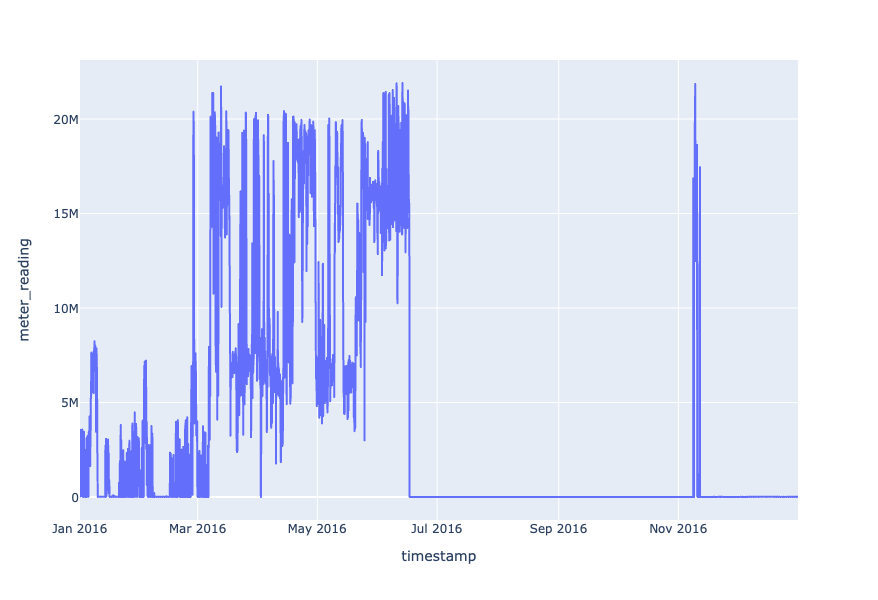

In [344]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

In [345]:
train_data.query("site_id == 13 & primary_use=='Education'").building_id.unique()

array([1079, 1080, 1083, 1085, 1088, 1095, 1099, 1107, 1121, 1126, 1130,
       1135, 1138, 1140, 1156, 1157, 1169, 1176, 1178, 1180, 1181, 1191,
       1198, 1201, 1217])

In [347]:
(train_data
 .query("site_id == 13 & meter==2 & primary_use=='Education'")
 .groupby("building_id")["meter_reading"]
 .max()
 .reset_index(name="max_reading"))

building_id   max_reading
0          1079  8.465000e+02
1          1080  8.703120e+03
2          1085  3.593750e+03
3          1088  4.443750e+04
4          1099  2.190470e+07
5          1107  4.087500e+04
6          1121  3.210940e+03
7          1126  9.243410e+03
8          1140  3.365620e+04
9          1156  4.190620e+04
10         1157  3.767580e+03
11         1169  1.331250e+04
12         1176  3.656250e+03
13         1178  1.559380e+04
14         1180  1.321600e+04
15         1191  1.248440e+04
16         1198  5.117190e+03

In [365]:
5e4/2.190470e7

0.002282615146521066

In [348]:
bids = train_data.query("site_id == 13 & primary_use=='Education'").building_id.unique()
building_metadata.query("building_id in @bids")

site_id  building_id primary_use  square_feet  year_built  floor_count
1079       13         1079   Education        14185         NaN          NaN
1080       13         1080   Education       207115         NaN          NaN
1083       13         1083   Education       100813         NaN          NaN
1085       13         1085   Education        58377         NaN          NaN
1088       13         1088   Education       287594         NaN          NaN
1095       13         1095   Education        32256         NaN          NaN
1099       13         1099   Education       332884         NaN          NaN
1107       13         1107   Education       184098         NaN          NaN
1121       13         1121   Education        85732         NaN          NaN
1126       13         1126   Education        72332         NaN          NaN
1130       13         1130   Education       280225         NaN          NaN
1135       13         1135   Education       150393         NaN          NaN
1138       13         1138   Education        39988         NaN          NaN
1140       13         1140   Education       156483         NaN          NaN
1156       13         1156   Education       259989         NaN          NaN
1157       13         1157   Education        37107         NaN          NaN
1169       13         1169   Education       155439         NaN          NaN
1176       13         1176   Education       142672         NaN          NaN
1178       13         1178   Education       133072         NaN          NaN
1180       13         1180   Education        95182         NaN          NaN
1181       13         1181   Education        60606         NaN          NaN
1191       13         1191   Education       192152         NaN          NaN
1198       13         1198   Education        85164         NaN          NaN
1201       13         1201   Education        73597         NaN          NaN
1217       13         1217   Education        73044         NaN          NaN

data cleaning and factor of correction for building 1099

In [361]:
idx = ts.query("timestamp.dt.month==11 & meter_reading > 1e5").index

In [362]:
ts.loc[idx,"meter_reading"] = ts.query("timestamp.dt.month==11").meter_reading.median()

/Users/martin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



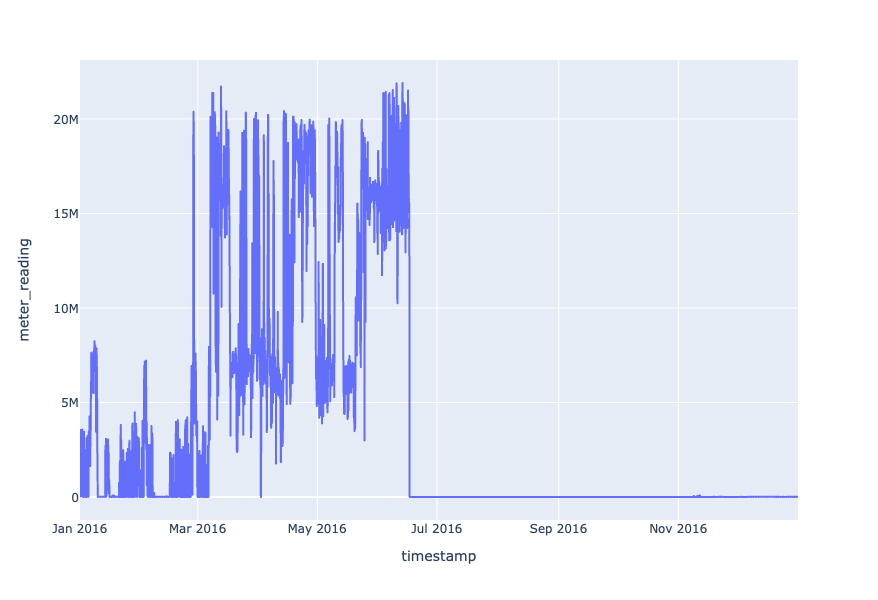

In [363]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

In [366]:
ts.meter_reading *= 5e4/2.190470e7

/Users/martin/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



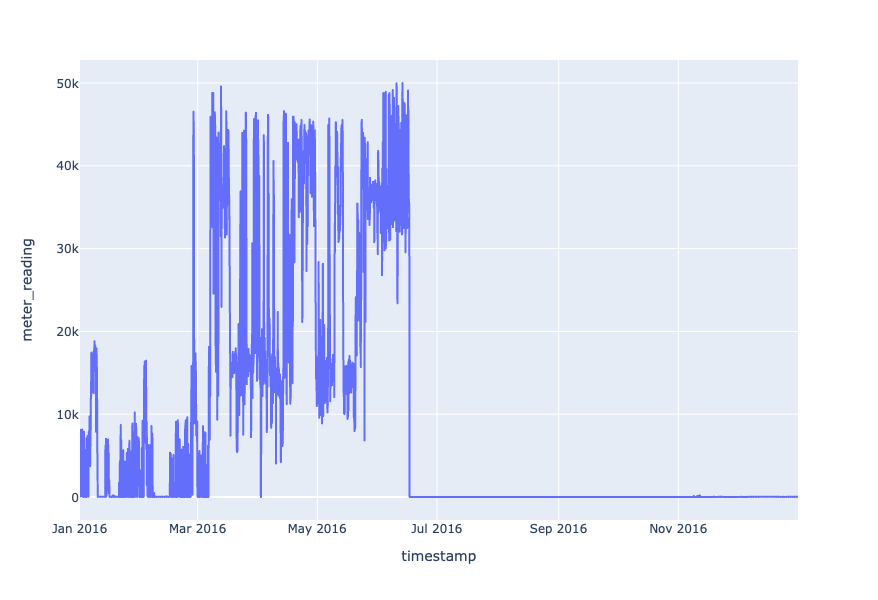

In [367]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

In [368]:
ts.meter_reading.describe()

count     8784.000000
mean      8512.456055
std      14202.527344
min          0.328697
25%          3.670445
50%         15.503521
75%      14254.160645
max      49999.996094
Name: meter_reading, dtype: float64

***
### `building_id = 778`

In [334]:
train_data.query("building_id == 778").meter.unique()

array([0, 1])

In [338]:
ts = train_data.query("building_id == 778 & meter == 1")

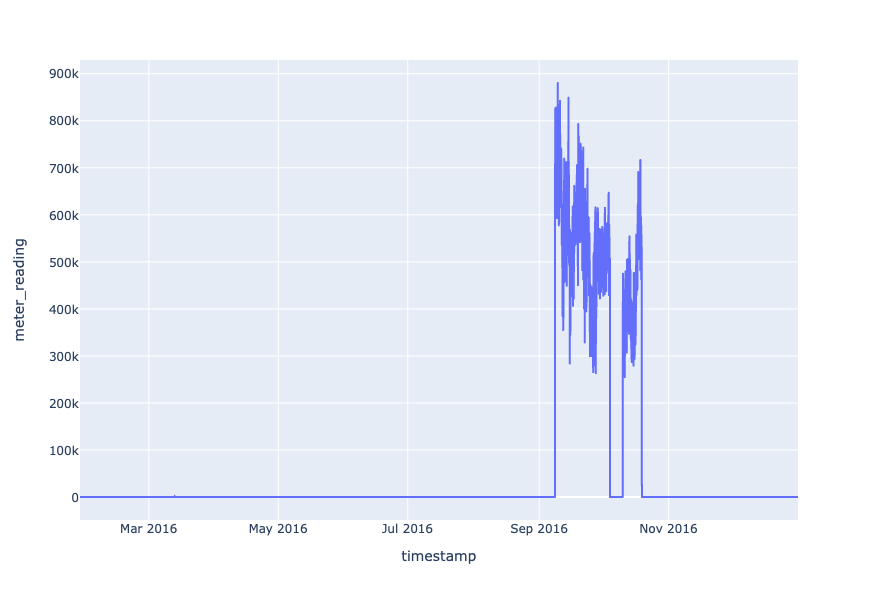

In [339]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

***
### `building_id = 53`

In [318]:
ts = train_data.query("building_id == 53 & meter==0")

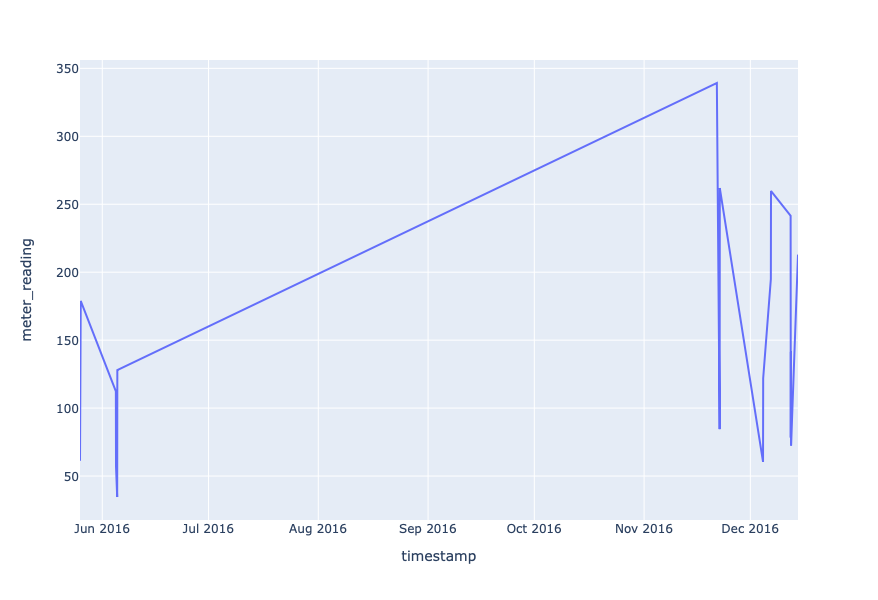

In [319]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

***
# Leak data analysis

In [5]:
leak_data = pd.read_feather("data/leakage.feather")

In [37]:
building_data = pd.read_csv("data/building_metadata.csv")

***
number of buildings by meter 

In [6]:
n_building = len(train_data.building_id.unique())
print(f"n_building in train: {n_building}")

n_building in train: 1449


In [7]:
train_data.groupby("meter").apply(lambda x: len(x.building_id.unique()))

meter
0    1413
1     498
2     324
3     145
dtype: int64

In [8]:
train_data.groupby("meter").apply(lambda x: len(x.building_id.unique())/n_building)

meter
0    0.975155
1    0.343685
2    0.223602
3    0.100069
dtype: float64

In [9]:
n_building = len(leak_data.building_id.unique())
print(f"n_building in leak: {n_building}")

n_building in leak: 463


In [10]:
leak_data.groupby("meter").apply(lambda x: len(x.building_id.unique()))

meter
0    424
1    165
2     43
3     55
dtype: int64

In [11]:
leak_data.groupby("meter").apply(lambda x: len(x.building_id.unique())/n_building)

meter
0    0.915767
1    0.356371
2    0.092873
3    0.118790
dtype: float64

***
number of `buildings & rows` by `site & meter`

In [88]:
df1 = (train_data.groupby(["site_id","meter"]).agg(
      n_buildings=("building_id", lambda x: len(x.unique())),
      n_rows=("timestamp", lambda x: len(x)))
      .reset_index())

In [89]:
df1

site_id  meter  n_buildings   n_rows
0         0      0          105   560062
1         0      1           24   167890
2         1      0           51   447978
3         1      3           12   105375
4         2      0          135  1174568
5         2      1           99   863845
6         2      3           55   481955
7         3      0          274  2362054
8         4      0           91   742867
9         5      0           89   773753
10        6      0           36   315394
11        6      1           21   164107
12        6      2           23   188590
13        7      0           12    92152
14        7      1           15   130956
15        7      2           12   104597
16        7      3            3    26344
17        8      0           70   541333
18        9      0          122  1023962
19        9      1           95   833113
20        9      2           89   777462
21       10      0           30   236082
22       10      1            9    78935
23       10      3           11    95899
24       11      0            5    43400
25       11      1            4    32656
26       11      3            5    43403
27       12      0           36   314489
28       13      0          141  1216786
29       13      1           80   702607
30       13      2           88   772496
31       14      0          102   850230
32       14      1           86   743017
33       14      2           43   371457
34       14      3           57   496264
35       15      0          114   828767
36       15      1           65   464951
37       15      2           69   494111
38       15      3            2    14797

In [90]:
df2 = (leak_data.groupby(["site_id","meter"]).agg(
      n_buildings=("building_id", lambda x: len(x.unique())),
      n_rows=("timestamp", lambda x: len(x)))
      .reset_index())

In [91]:
df2

site_id  meter  n_buildings   n_rows
0        0      0          105  2364809
1        0      1           24   588733
2        1      0           50  1299462
3        2      0          134  3480562
4        2      1           98  2572023
5        2      3           55  1445555
6        4      0           74  1905561
7       15      0           61  1012598
8       15      1           43   718782
9       15      2           43   727682

***

In [92]:
summary = (train_data.groupby(["site_id","meter","primary_use"]).agg(
      n_buildings=("building_id", lambda x: len(x.unique())),
      n_rows=("timestamp", lambda x: len(x)))
      .reset_index())

In [93]:
summary.query("site_id == 0")

site_id  meter                    primary_use  n_buildings  n_rows
0         0      0                      Education           30  160163
1         0      0  Entertainment/public assembly            5   26695
2         0      0            Lodging/residential           27  145961
3         0      0                         Office           24  124345
4         0      0                          Other            5   27029
5         0      0                        Parking            8   42958
6         0      0                         Retail            6   32911
7         0      1                      Education           12   86849
8         0      1            Lodging/residential            4   26090
9         0      1                         Office            6   42548
10        0      1                          Other            1    5147
11        0      1                         Retail            1    7256

In [94]:
summary.query("site_id == 1")

site_id  meter                    primary_use  n_buildings  n_rows
12        1      0                      Education           22  193244
13        1      0  Entertainment/public assembly            1    8784
14        1      0            Lodging/residential           10   87840
15        1      0                         Office           16  140542
16        1      0                Public services            2   17568
17        1      3                      Education            8   70245
18        1      3                         Office            2   17567
19        1      3                Public services            2   17563

In [95]:
summary.query("site_id == 2")

site_id  meter                    primary_use  n_buildings  n_rows
20        2      0                      Education           61  528084
21        2      0  Entertainment/public assembly           21  182672
22        2      0         Food sales and service            2   17563
23        2      0                     Healthcare            1    8745
24        2      0            Lodging/residential           12  105359
25        2      0                         Office           24  210256
26        2      0                        Parking            3   26332
27        2      0                Public services            6   52660
28        2      0              Religious worship            1    8022
29        2      0                         Retail            1    8776
30        2      0                        Utility            1    8783
31        2      0              Warehouse/storage            2   17316
32        2      1                      Education           52  454484
33        2      1  Entertainment/public assembly            9   79024
34        2      1         Food sales and service            2   17564
35        2      1                     Healthcare            1    8783
36        2      1            Lodging/residential           12  105382
37        2      1                         Office           17  145916
38        2      1                Public services            4   35126
39        2      1                         Retail            1    8783
40        2      1                        Utility            1    8783
41        2      3                      Education           31  271944
42        2      3  Entertainment/public assembly            7   61473
43        2      3         Food sales and service            1    8781
44        2      3            Lodging/residential            9   78282
45        2      3                         Office            6   52694
46        2      3                Public services            1    8781

In [98]:
summary.query("site_id == 4")

site_id  meter                    primary_use  n_buildings  n_rows
58        4      0                      Education           66  553524
59        4      0  Entertainment/public assembly            9   62185
60        4      0            Lodging/residential            4   29673
61        4      0                        Parking            3   20589
62        4      0                Public services            6   50602
63        4      0             Technology/science            2   17544
64        4      0                        Utility            1    8750

In [99]:
summary.query("site_id == 15")

site_id  meter                    primary_use  n_buildings  n_rows
193       15      0                      Education           41  296715
194       15      0  Entertainment/public assembly           15  102254
195       15      0            Lodging/residential           28  207928
196       15      0       Manufacturing/industrial            2   14944
197       15      0                         Office           18  132215
198       15      0                Public services            6   44825
199       15      0              Religious worship            1    7471
200       15      0             Technology/science            1    7472
201       15      0                        Utility            2   14943
202       15      1                      Education           23  168142
203       15      1  Entertainment/public assembly            7   47931
204       15      1                     Healthcare            1    7332
205       15      1            Lodging/residential           13   89054
206       15      1       Manufacturing/industrial            1    6677
207       15      1                         Office           16  116739
208       15      1                Public services            2   14417
209       15      1              Religious worship            1    7327
210       15      1             Technology/science            1    7332
211       15      2                      Education           29  206114
212       15      2  Entertainment/public assembly            9   65089
213       15      2            Lodging/residential           12   80949
214       15      2       Manufacturing/industrial            1    7468
215       15      2                         Office           12   89662
216       15      2                Public services            3   22413
217       15      2             Technology/science            1    7472
218       15      2                        Utility            2   14944
219       15      3                      Education            1    7332
220       15      3  Entertainment/public assembly            1    7465

***
#### mirror dataset for `site_id = 6 & meter == 0` on `site_id == 2 & meter == 0`

In [140]:
summary.query("site_id==6 & meter==0")

site_id  meter                    primary_use  n_buildings  n_rows
73        6      0                      Education           13  113891
74        6      0  Entertainment/public assembly            3   26319
75        6      0            Lodging/residential           11   96438
76        6      0                         Office            8   69971
77        6      0                Public services            1    8775

In [141]:
summary.query("site_id==2 & meter==0")

site_id  meter                    primary_use  n_buildings  n_rows
20        2      0                      Education           61  528084
21        2      0  Entertainment/public assembly           21  182672
22        2      0         Food sales and service            2   17563
23        2      0                     Healthcare            1    8745
24        2      0            Lodging/residential           12  105359
25        2      0                         Office           24  210256
26        2      0                        Parking            3   26332
27        2      0                Public services            6   52660
28        2      0              Religious worship            1    8022
29        2      0                         Retail            1    8776
30        2      0                        Utility            1    8783
31        2      0              Warehouse/storage            2   17316

In [142]:
mirrors = find_mirror_buildings(train_data, building_data, summary, site_id_source, site_id_target, meter)

In [146]:
train_data.query("building_id in @mirrors")

building_id  meter           timestamp  meter_reading  site_id  \
81                167      0 2016-01-01 00:00:00      58.520000        2   
82                167      1 2016-01-01 00:00:00       0.000000        2   
83                167      3 2016-01-01 00:00:00      41.029900        2   
95                172      0 2016-01-01 00:00:00     111.080002        2   
96                172      1 2016-01-01 00:00:00       0.000000        2   
...               ...    ...                 ...            ...      ...   
19676820          287      0 2016-12-31 23:00:00      22.770000        2   
19676821          287      1 2016-12-31 23:00:00       1.230900        2   
19676822          287      3 2016-12-31 23:00:00       0.000000        2   
19676825          290      0 2016-12-31 23:00:00      22.200001        2   
19676826          290      1 2016-12-31 23:00:00       0.175800        2   

                  primary_use  square_feet  air_temperature  dew_temperature  \
81        Lodging/residential        86323         7.199219        -5.601562   
82        Lodging/residential        86323         7.199219        -5.601562   
83        Lodging/residential        86323         7.199219        -5.601562   
95                     Office       121440         7.199219        -5.601562   
96                     Office       121440         7.199219        -5.601562   
...                       ...          ...              ...              ...   
19676820               Office        33713        16.703125        10.000000   
19676821               Office        33713        16.703125        10.000000   
19676822               Office        33713        16.703125        10.000000   
19676825               Office        51732        16.703125        10.000000   
19676826               Office        51732        16.703125        10.000000   

          sea_level_pressure  wind_direction  wind_speed  
81                    1017.5             0.0    0.000000  
82                    1017.5             0.0    0.000000  
83                    1017.5             0.0    0.000000  
95                    1017.5             0.0    0.000000  
96                    1017.5             0.0    0.000000  
...                      ...             ...         ...  
19676820              1011.0           250.0    2.599609  
19676821              1011.0           250.0    2.599609  
19676822              1011.0           250.0    2.599609  
19676825              1011.0           250.0    2.599609  
19676826              1011.0           250.0    2.599609  

[705399 rows x 12 columns]

***

Percentage of time-series completion for `meter & site` partitions.

In [21]:
ts_length = (train_data
             .groupby(["building_id","meter"])["timestamp"]
             .count()
             .reset_index(name="length"))
max_length = ts_length.length.max()
ts_length["completion"] = ts_length.length/max_length

In [22]:
ts_length.completion.describe()

count    2380.000000
mean        0.941298
std         0.124267
min         0.002277
25%         0.961464
50%         0.998520
75%         0.999886
max         1.000000
Name: completion, dtype: float64

In [24]:
mrg = pd.merge(train_data, ts_length, how="left", on=["building_id", "meter"])

In [37]:
mrg.groupby(["meter","site_id"]).agg({"completion": [np.mean, 
                                                     np.median, 
                                                     lambda x: x.quantile(0.25),
                                                     lambda x: x.quantile(0.75)]})

completion                                
                    mean    median <lambda_0> <lambda_1>
meter site_id                                           
0     0         0.614437  0.615437   0.615323   0.615437
      1         0.999987  1.000000   1.000000   1.000000
      2         0.992069  0.999658   0.998748   0.999772
      3         0.989811  0.998975   0.996926   0.999772
      4         0.965432  0.999658   0.997382   0.999886
      5         0.991138  0.995446   0.994763   1.000000
      6         0.997397  0.998975   0.998292   0.999089
      7         0.932589  0.999658   0.999658   0.999772
      8         0.900695  0.906079   0.887864   0.956170
      9         0.961793  0.973133   0.972450   0.975524
      10        0.932130  0.982810   0.959586   0.997609
      11        0.988337  0.989640   0.989413   0.998748
      12        0.994685  0.999886   0.999658   0.999886
      13        0.992173  0.999886   0.998406   1.000000
      14        0.954526  0.982354   0.923383   0.990551
      15        0.841137  0.850524   0.849727   0.850638
1     0         0.802938  0.827413   0.822860   0.827527
      2         0.995452  0.999772   0.999658   0.999886
      6         0.900905  0.856671   0.852345   0.996585
      7         0.993988  0.999658   0.978597   0.999658
      9         0.998365  0.998520   0.998179   0.999317
      10        0.998470  0.998748   0.998179   0.998862
      11        0.942446  0.989526   0.989413   0.999772
      13        0.999841  1.000000   1.000000   1.000000
      14        0.987099  1.000000   1.000000   1.000000
      15        0.826271  0.834699   0.834130   0.834699
2     6         0.970027  0.998406   0.997268   0.999772
      7         0.992406  0.999658   0.978597   0.999658
      9         0.996302  0.999317   0.998975   0.999545
      13        0.999368  1.000000   1.000000   1.000000
      14        0.986827  1.000000   0.998292   1.000000
      15        0.833718  0.850638   0.850410   0.850638
3     1         0.999687  0.999886   0.999545   1.000000
      2         0.997649  0.999772   0.999658   0.999886
      7         0.999696  0.999772   0.999545   0.999772
      10        0.992728  0.998748   0.991803   0.998862
      11        0.988405  0.989640   0.989413   0.998975
      14        0.993585  1.000000   0.998520   1.000000
      15        0.842338  0.849841   0.834699   0.849841

***